<a href="https://colab.research.google.com/github/dokin0802/SinGAN/blob/master/ep100_aug10%2Bpeo120.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [9]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import shutil
import os

shutil.rmtree('/content/drive/MyDrive/architecture_aug/ex2/augf2/Gothic')
os.mkdir('/content/drive/MyDrive/architecture_aug/ex2/augf2/Gothic')

In [14]:
import os
import glob
path = '/content/drive/MyDrive/architecture_aug/ex2/augf2/Gothic'
g = glob.glob(path+'/*')

def rename(files):
  for i,f in enumerate(files):
      os.rename(f, os.path.join(path, 'g_' + '{0:03d}.jpg'.format(i)))

In [15]:
rename(g)


In [16]:
dir_ = Path('/content/drive/MyDrive/architecture_aug/ex2/augf2')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/architecture_aug/ex2/au...,International
1,/content/drive/MyDrive/architecture_aug/ex2/au...,Gothic
2,/content/drive/MyDrive/architecture_aug/ex2/au...,Postmodern
3,/content/drive/MyDrive/architecture_aug/ex2/au...,Romanesque
4,/content/drive/MyDrive/architecture_aug/ex2/au...,Deconstructivism


In [17]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 1380

Number of different labels: 6

Labels: ['International' 'Gothic' 'Postmodern' 'Romanesque' 'Deconstructivism'
 'Baroque']


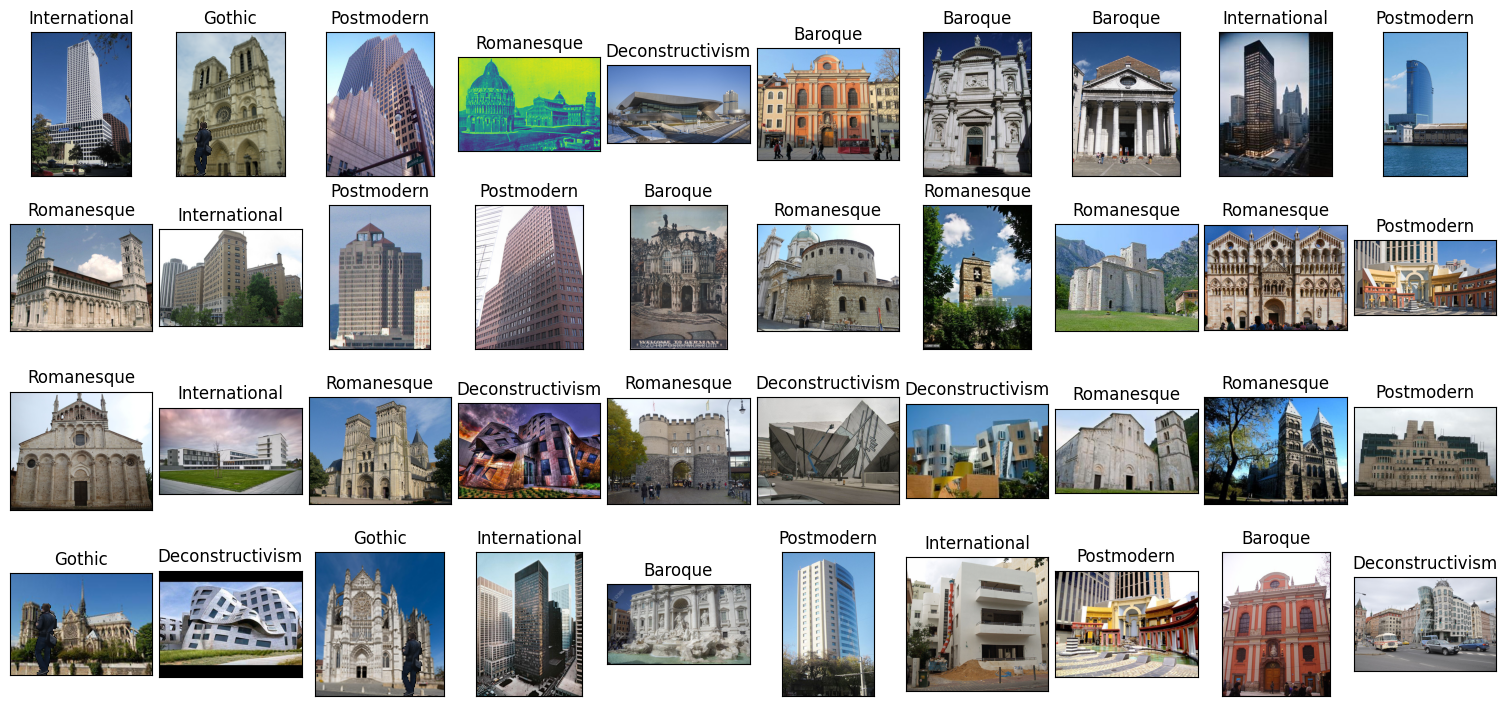

In [18]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

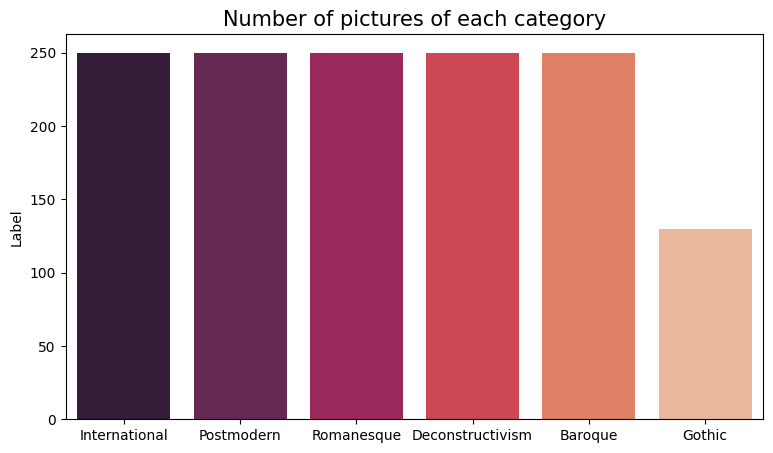

In [19]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [20]:
train_df =df

dir_ = Path('/content/drive/MyDrive/architecture_small/test')
filepaths = list(dir_.glob(r'**/*.jpg'))
test_df = proc_img(filepaths)

In [21]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.20)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/architecture_aug/ex2/augf2',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/drive/MyDrive/architecture_aug/ex2/augf2',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 1104 images belonging to 6 classes.
Found 276 images belonging to 6 classes.


In [22]:

test_datagen =  ImageDataGenerator(rescale=1/255)

test_gen  = test_datagen.flow_from_directory('/content/drive/MyDrive/architecture_small/test',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 300 images belonging to 6 classes.


In [23]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.20
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [24]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [25]:
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [26]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode="min", factor=0.5, patience=2, min_delta=0.001)


early_stop= EarlyStopping(monitor = "val_loss",
                          mode="min", min_delta=0.001,
                          restore_best_weights=True,
                            patience=10, verbose=1)

In [27]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
start = perf_counter()
history = model.fit(train_images,validation_data=val_images,epochs=100,callbacks = [early_stop, reduce_lr])
duration = perf_counter() - start
print(duration)


Found 1104 validated image filenames belonging to 6 classes.
Found 276 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
74836368/74836368 [==============================] - 5s 0us/step
Epoch 1/100
35/35 [==============================] - 550s 15s/step - loss: 0.9200 - accuracy: 0.6250 - val_loss: 0.8001 - val_accuracy: 0.6703 - lr: 0.0010
Epoch 2/100
35/35 [==============================] - 11s 301ms/step - loss: 0.4942 - accuracy: 0.8062 - val_loss: 0.6811 - val_accuracy: 0.7065 - lr: 0.0010
Epoch 3/100
35/35 [==============================] - 11s 302ms/step - loss: 0.3518 - accuracy: 0.8678 - val_loss: 0.6362 - val_accuracy: 0.7283 - lr: 0.0010
Epoch 4/100
35/35 [==============================] - 11s 314ms/step - loss: 0.2573 - accuracy: 0.9130 - val_loss: 0.4901 - val_accuracy: 0.8007 - lr: 0.0010
Epoch 5/100
35/35 [==============================] - 10s 292ms/step - loss: 0.2056 - accuracy: 0.9348 - val_loss: 0.6008 - val_

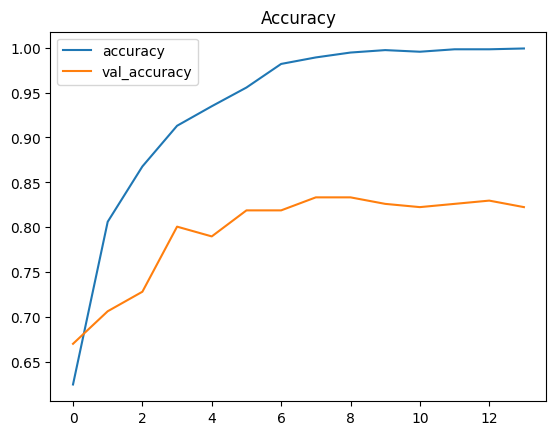

In [28]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

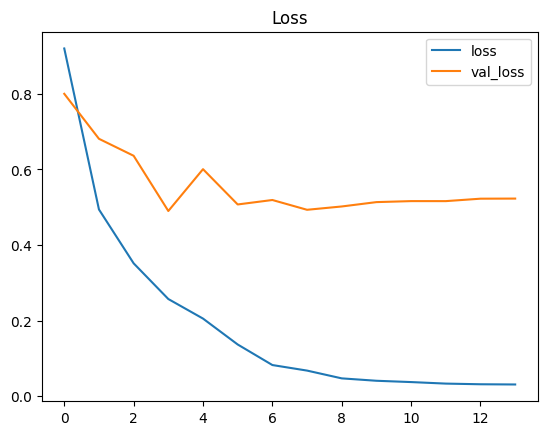

In [29]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [30]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 151s 16s/step
Accuracy on the test set: 68.67%


In [31]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                  precision    recall  f1-score   support

         Baroque       0.67      1.00      0.80        50
Deconstructivism       0.80      0.78      0.79        50
          Gothic       0.62      0.20      0.30        50
   International       0.79      0.68      0.73        50
      Postmodern       0.62      0.70      0.66        50
      Romanesque       0.62      0.76      0.68        50

        accuracy                           0.69       300
       macro avg       0.69      0.69      0.66       300
    weighted avg       0.69      0.69      0.66       300



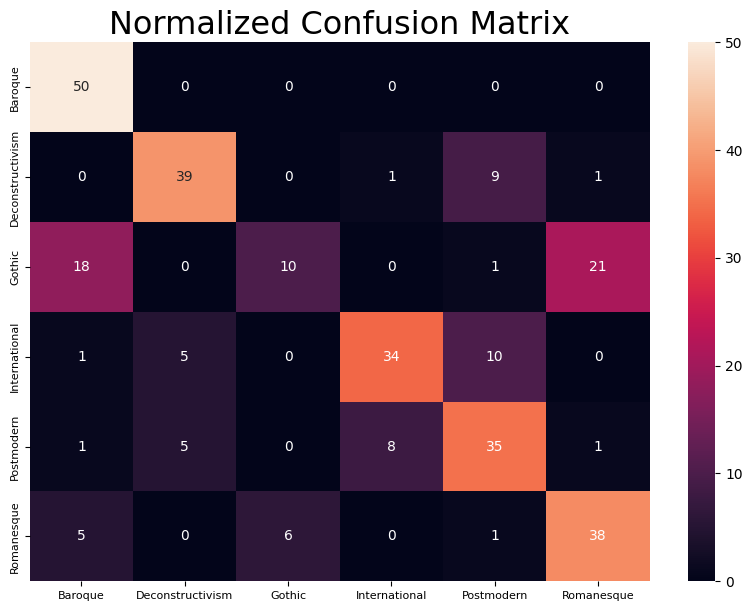

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred)#, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

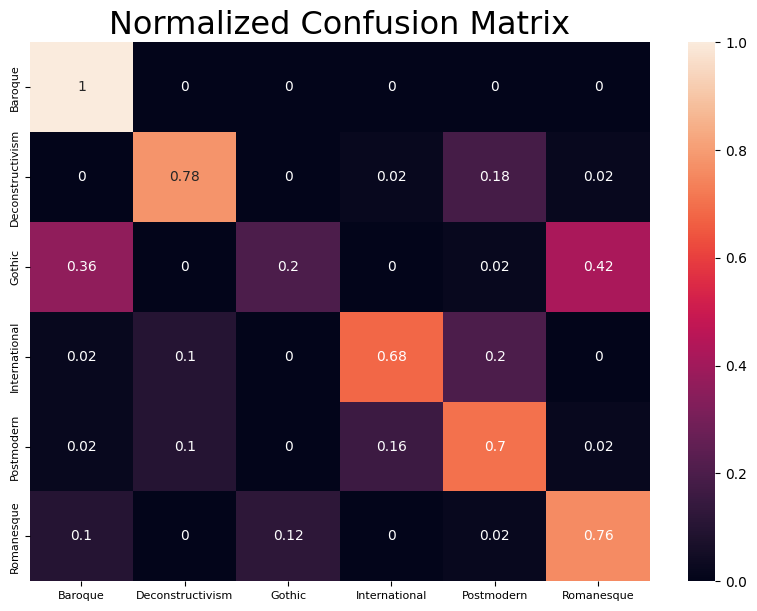

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
model()

In [ ]:
import shutil
shutil.rmtree('/content/drive/MyDrive/architecture_aug/ex2/augf2/.ipynb_checkpoints')

In [ ]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet121)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1536 validated image filenames belonging to 6 classes.
Found 384 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/4
48/48 [==============================] - 20s 284ms/step - loss: 0.8317 - accuracy: 0.6908 - val_loss: 0.6095 - val_accuracy: 0.7474
Epoch 2/4
48/48 [==============================] - 12s 242ms/step - loss: 0.3996 - accuracy: 0.8509 - val_loss: 0.3515 - val_accuracy: 0.8542
Epoch 3/4
48/48 [==============================] - 12s 241ms/step - loss: 0.3456 - accuracy: 0.8770 - val_loss: 0.3288 - val_accuracy: 0.8594
Epoch 4/4
48/48 [==============================] - 12s 244ms/step - loss: 0.2448 - accuracy: 0.9049 - val_loss: 0.3205 - val_accuracy: 0.8906


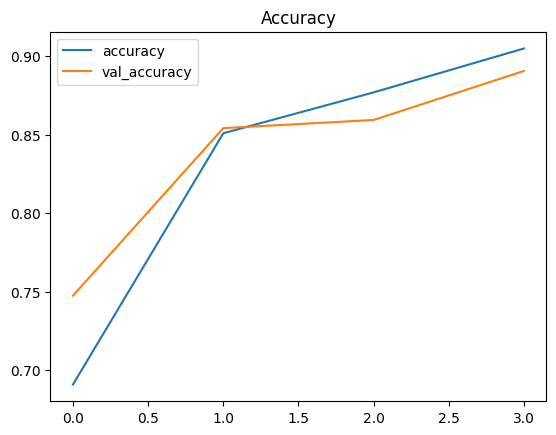

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

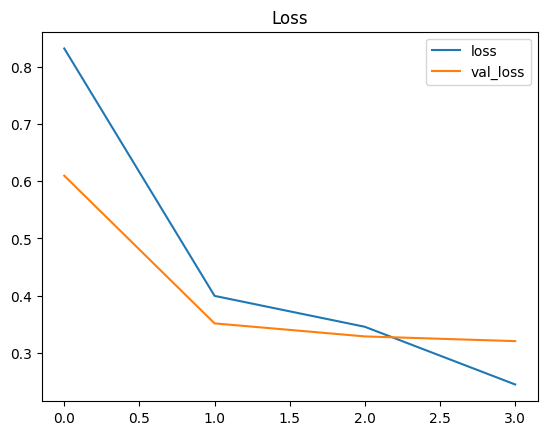

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 5s 315ms/step
Accuracy on the test set: 63.00%


In [ ]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                  precision    recall  f1-score   support

         Baroque       0.82      0.92      0.87        50
Deconstructivism       0.67      0.84      0.74        50
          Gothic       0.50      0.08      0.14        50
   International       0.74      0.50      0.60        50
      Postmodern       0.58      0.58      0.58        50
      Romanesque       0.48      0.86      0.62        50

        accuracy                           0.63       300
       macro avg       0.63      0.63      0.59       300
    weighted avg       0.63      0.63      0.59       300



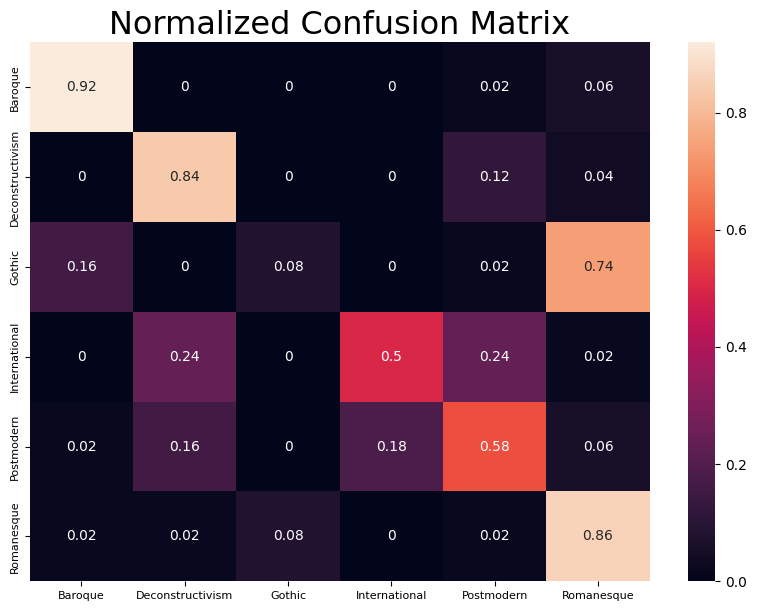

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.Xception)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1536 validated image filenames belonging to 6 classes.
Found 384 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/4
48/48 [==============================] - 17s 260ms/step - loss: 0.7236 - accuracy: 0.7064 - val_loss: 0.4037 - val_accuracy: 0.8516
Epoch 2/4
48/48 [==============================] - 12s 241ms/step - loss: 0.3995 - accuracy: 0.8418 - val_loss: 0.3760 - val_accuracy: 0.8646
Epoch 3/4
48/48 [==============================] - 12s 242ms/step - loss: 0.3316 - accuracy: 0.8613 - val_loss: 0.4016 - val_accuracy: 0.8542
Epoch 4/4
48/48 [==============================] - 12s 244ms/step - loss: 0.2494 - accuracy: 0.9128 - val_loss: 0.3707 - val_accuracy: 0.8646


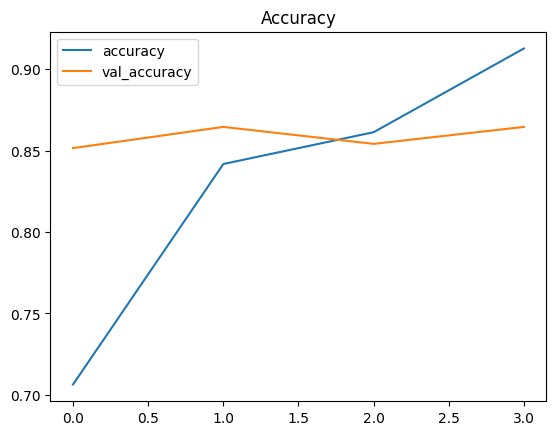

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

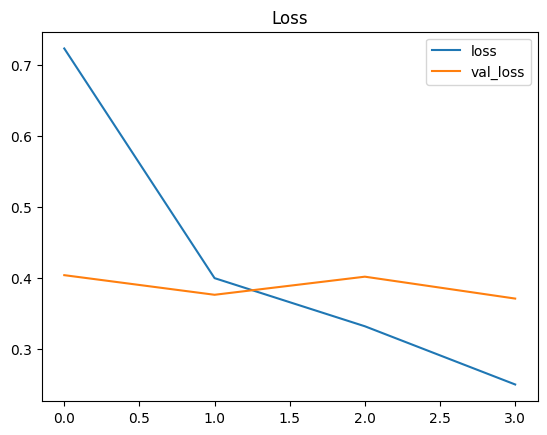

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 4s 330ms/step
Accuracy on the test set: 62.00%


In [ ]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                  precision    recall  f1-score   support

         Baroque       0.68      0.98      0.80        50
Deconstructivism       0.56      0.80      0.66        50
          Gothic       0.76      0.26      0.39        50
   International       0.71      0.50      0.59        50
      Postmodern       0.53      0.46      0.49        50
      Romanesque       0.58      0.72      0.64        50

        accuracy                           0.62       300
       macro avg       0.64      0.62      0.60       300
    weighted avg       0.64      0.62      0.60       300



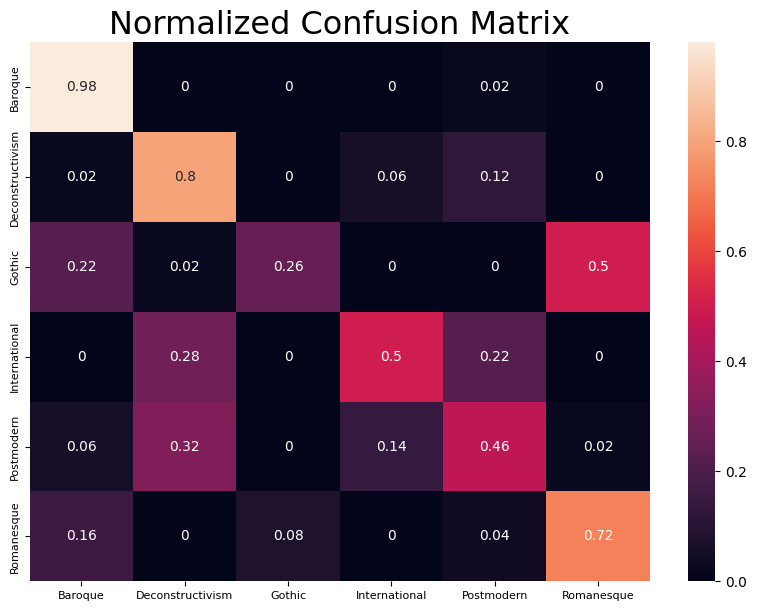

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet152V2)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1536 validated image filenames belonging to 6 classes.
Found 384 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
234545216/234545216 [==============================] - 1s 0us/step
Epoch 1/4
48/48 [==============================] - 24s 297ms/step - loss: 0.6559 - accuracy: 0.7311 - val_loss: 0.3451 - val_accuracy: 0.8698
Epoch 2/4
48/48 [==============================] - 12s 247ms/step - loss: 0.3142 - accuracy: 0.8763 - val_loss: 0.3166 - val_accuracy: 0.8854
Epoch 3/4
48/48 [==============================] - 12s 245ms/step - loss: 0.1817 - accuracy: 0.9349 - val_loss: 0.3176 - val_accuracy: 0.8802
Epoch 4/4
48/48 [==============================] - 12s 250ms/step - loss: 0.1152 - accuracy: 0.9622 - val_loss: 0.3063 - val_accuracy: 0.9089


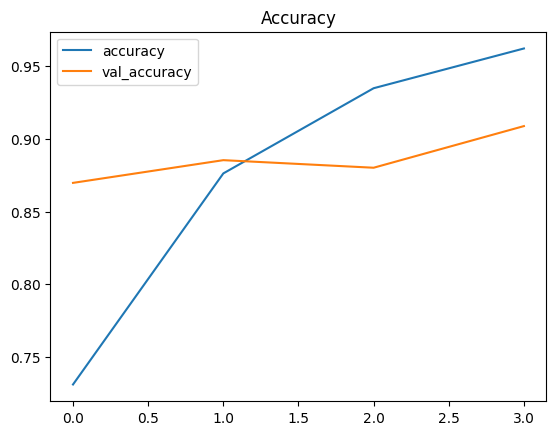

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

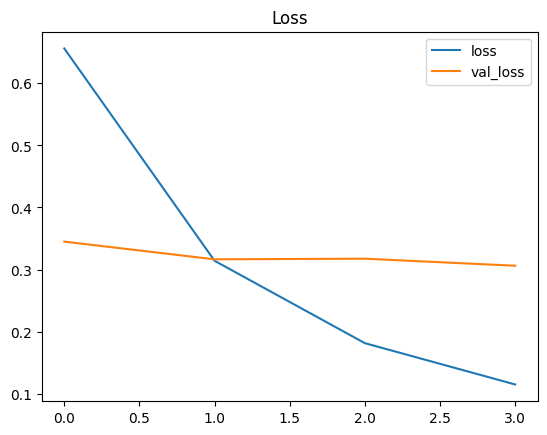

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 6s 340ms/step
Accuracy on the test set: 66.00%


In [ ]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                  precision    recall  f1-score   support

         Baroque       0.78      0.98      0.87        50
Deconstructivism       0.66      0.78      0.72        50
          Gothic       0.65      0.30      0.41        50
   International       0.82      0.66      0.73        50
      Postmodern       0.56      0.54      0.55        50
      Romanesque       0.52      0.70      0.60        50

        accuracy                           0.66       300
       macro avg       0.67      0.66      0.65       300
    weighted avg       0.67      0.66      0.65       300



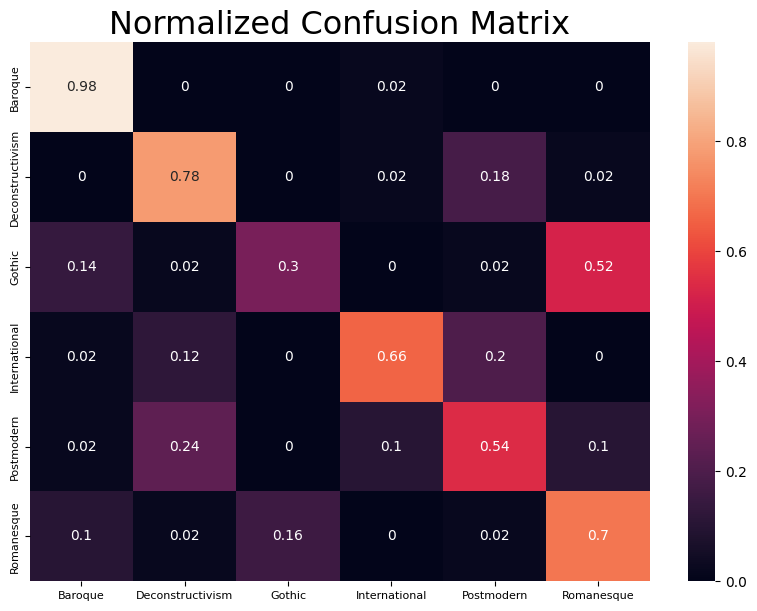

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.InceptionV3)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1536 validated image filenames belonging to 6 classes.
Found 384 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/4
48/48 [==============================] - 19s 273ms/step - loss: 0.7611 - accuracy: 0.6901 - val_loss: 0.4542 - val_accuracy: 0.7812
Epoch 2/4
48/48 [==============================] - 12s 245ms/step - loss: 0.4156 - accuracy: 0.8327 - val_loss: 0.3889 - val_accuracy: 0.8229
Epoch 3/4
48/48 [==============================] - 12s 246ms/step - loss: 0.3142 - accuracy: 0.8789 - val_loss: 0.3653 - val_accuracy: 0.8594
Epoch 4/4
48/48 [==============================] - 12s 243ms/step - loss: 0.2233 - accuracy: 0.9141 - val_loss: 0.4520 - val_accuracy: 0.8047


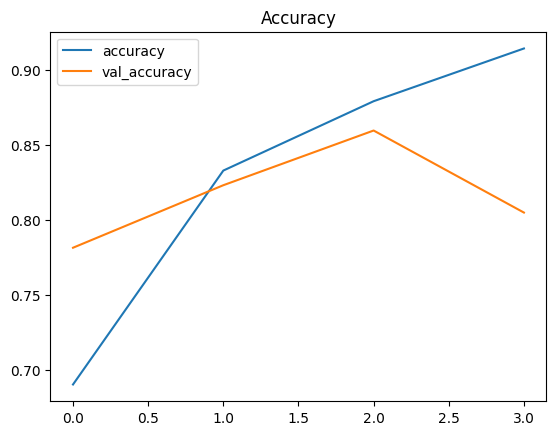

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

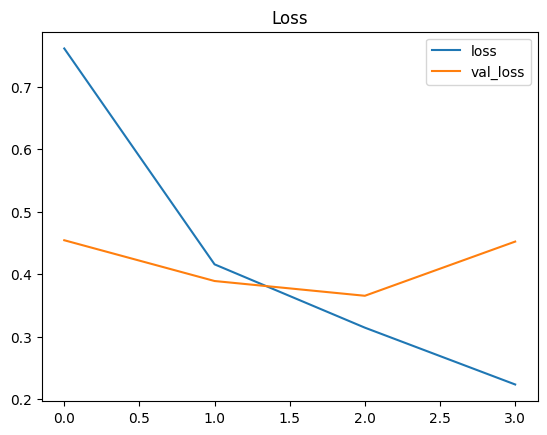

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 5s 376ms/step
Accuracy on the test set: 58.67%


In [ ]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                  precision    recall  f1-score   support

         Baroque       0.92      0.70      0.80        50
Deconstructivism       0.64      0.84      0.72        50
          Gothic       0.58      0.14      0.23        50
   International       0.86      0.48      0.62        50
      Postmodern       0.48      0.50      0.49        50
      Romanesque       0.41      0.86      0.56        50

        accuracy                           0.59       300
       macro avg       0.65      0.59      0.57       300
    weighted avg       0.65      0.59      0.57       300



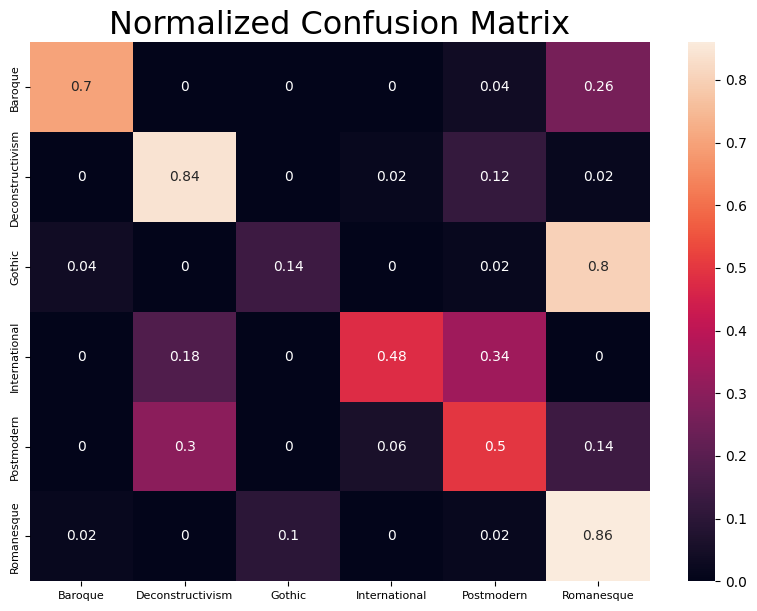

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()